In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from assimilation_schemes import OI

plt.style.use('seaborn')

In [2]:
def lorenz63_fdm(x0, ts, sigma=10, r=28, b=8/3):
    """Solve lorenz63 with finit difference method"""    
    size = ts.size
    dt = ts[1] - ts[0]
    
    x = np.zeros((size,))
    y = np.zeros((size,))
    z = np.zeros((size,))
    x[0] = x0[0]
    y[0] = x0[1]
    z[0] = x0[2]
    
    for i in range(1, size):
        x[i] = x[i-1] + sigma * (y[i-1] - x[i-1]) * dt
        y[i] = y[i-1] + (r*x[i-1] - y[i-1] - x[i-1]*z[i-1]) * dt
        z[i] = z[i-1] + (x[i-1]*y[i-1] - b*z[i-1]) * dt
    
    return np.vstack((x, y, z))

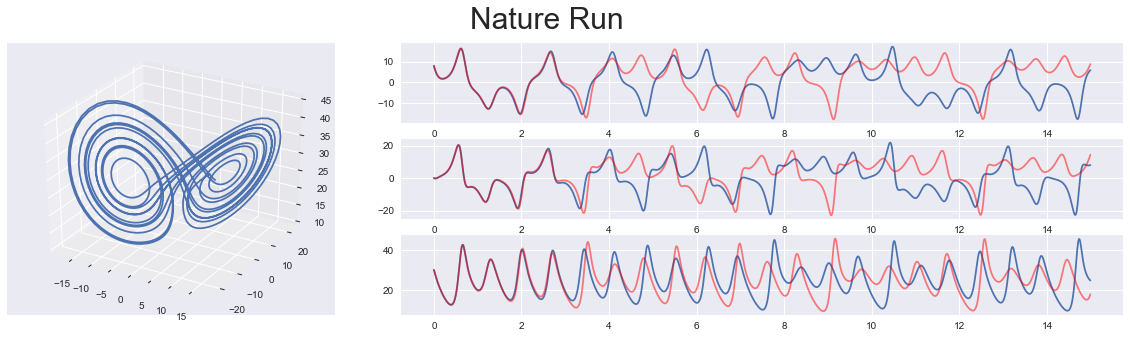

In [3]:
time = 15
dt = 0.01
ts = np.arange(0, time, dt)
X0 = np.array([[8, 0, 30]]).T
X_nature = lorenz63_fdm(X0.ravel(), ts)

X0_per = X0 + 0.1
X_per = lorenz63_fdm(X0_per.ravel(), ts)

# plot nature run
fig = plt.figure(figsize=(20,5))
gs = fig.add_gridspec(nrows=3, ncols=3)

ax_line1 = fig.add_subplot(gs[0,1:])
ax_line2 = fig.add_subplot(gs[1,1:])
ax_line3 = fig.add_subplot(gs[2,1:])
ax_3d = fig.add_subplot(gs[:,0], projection='3d')

ax_line1.plot(ts, X_nature[0,:])
ax_line1.plot(ts, X_per[0,:], color='red', alpha=0.5)
ax_line2.plot(ts, X_nature[1,:])
ax_line2.plot(ts, X_per[1,:], color='red', alpha=0.5)
ax_line3.plot(ts, X_nature[2,:])
ax_line3.plot(ts, X_per[2,:], color='red', alpha=0.5)
ax_3d.plot(X_nature[0,:], X_nature[1,:], X_nature[2,:])

fig.suptitle('Nature Run', fontsize=30);

### Simulated Obs

In [4]:
def gen_random_normal(mean, var, size, random_state=None):
    """
    Generate random gaussian distribution numbers
    
    Parameters:
    ----------
    mean, var: scaler or array-like.
        If array-like, its length should equal to 'size'.
    size: int
        The amount of random numbers.
    random_state: int
        If None, np.random.randint(0, 99) will be used.
        
    Return:
    ------
    An 1d array of random numbers.
    """
    if random_state is None:
        random_state = np.random.randint(0, 99)
        
    mean = np.array(mean)
    var = np.array(var)
    
    rng = np.random.RandomState(random_state)
    result = rng.randn(max(mean.size, var.size, size))
    result = (result + mean) * np.sqrt(var)
    return result

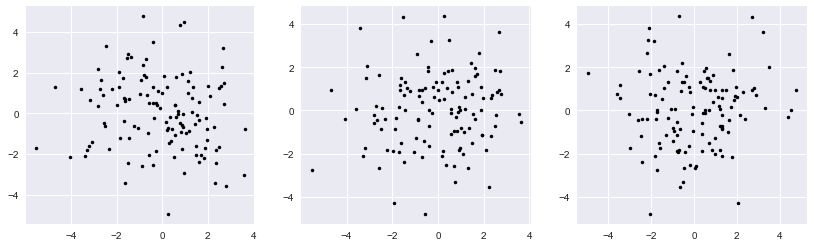

In [10]:
# observation parameters for each variables
obs_mean = [0, 0, 0]
obs_var = [3, 3, 3]
random_state = [20, 21, 22]

# assimilate observation parameters
obs_timeintv = 0.12
cycle_num = int(time / obs_timeintv)

# construct observation error
X_obs_err = np.zeros((3, cycle_num))
for irow, (obsm, obsv, rst) in enumerate(zip(obs_mean, obs_var, random_state)):
    X_obs_err[irow,:] = gen_random_normal(obsm, obsv, cycle_num, rst)
    
X_obs = X_nature[:,::int(obs_timeintv/dt)] + X_obs_err

# plot observation errors
fig, axs = plt.subplots(figsize=(14, 4), nrows=1, ncols=3)
axs[0].plot(X_obs_err[0], X_obs_err[1], 'k.')
axs[1].plot(X_obs_err[0], X_obs_err[2], 'k.')
axs[2].plot(X_obs_err[1], X_obs_err[2], 'k.')

### Initial value

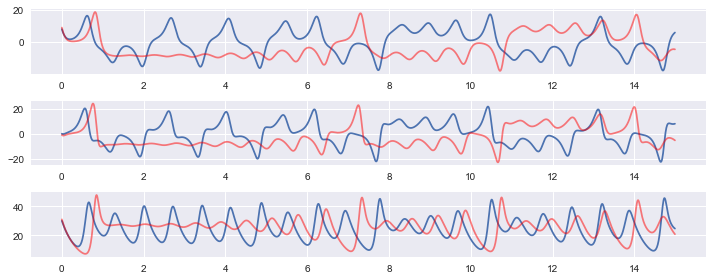

In [11]:
X_ini = X_nature[:,[0]] + np.array([[1], [-1], [1]])

# no assimilation
X_no_assim = lorenz63_fdm(X_ini.ravel(), ts)


fig, axs = plt.subplots(nrows=3, figsize=(10, 4))
for i in range(3):
    axs[i].plot(ts, X_nature[i,:])
    axs[i].plot(ts, X_no_assim[i,:], color='red', alpha=0.5)
plt.tight_layout()

### KF

In [12]:
#def M(xi, yi, zi, dt, sigma=10, r=28, b=8/3):
#    M = np.array([
#        [-sigma, sigma, 0],
#        [r, -1, -xi],
#        [0.5*yi, 0.5*xi, -b]
#    ]) * dt
#    return M

def M(xi, yi, zi, dt, sigma=10, r=28, b=8/3):
    M = np.array([
        [1-sigma*dt, sigma*dt, 0],
        [r*dt, 1-dt, -xi*dt],
        [0, xi*dt, 1-b*dt]
    ])
    return M

M(X_ini[0,0], X_ini[1,0], X_ini[2,0], dt)

array([[ 0.9       ,  0.1       ,  0.        ],
       [ 0.28      ,  0.99      , -0.09      ],
       [ 0.        ,  0.09      ,  0.97333333]])

========Some Parameters=========
cycle length (time interval between two observations): 0.12 sec
number of cycle: 125
dt = 0.01 sec
initial value for experiment: [ 9. -1. 31.]
initial value for nature run: [ 8.  0. 30.]
=== Pb ===
[[19.1849751  21.76544331  2.70434038]
 [21.76544331 27.19471019  3.67928494]
 [ 2.70434038  3.67928494 12.99742007]]
=== Pa ===
[[1.61442074 0.99820927 0.0046496 ]
 [0.99820927 1.97420309 0.06717967]
 [0.0046496  0.06717967 2.42117246]]
=== Pb ===
[[1.8085206  1.82238386 0.13108158]
 [1.82238386 3.14675999 0.06530281]
 [0.13108158 0.06530281 2.78583109]]
=== Pa ===
[[0.89032748 0.62504029 0.04074131]
 [0.62504029 1.35045546 0.0044572 ]
 [0.04074131 0.0044572  1.44350252]]
=== Pb ===
[[1.01661248 1.11769275 0.06723436]
 [1.11769275 2.08821349 0.02213591]
 [0.06723436 0.02213591 1.64266727]]
=== Pa ===
[[0.61289588 0.52421917 0.03207022]
 [0.52421917 1.11604863 0.00139089]
 [0.03207022 0.00139089 1.06098812]]
=== Pb ===
[[0.72235872 0.89536946 0.04726647]
 [0.

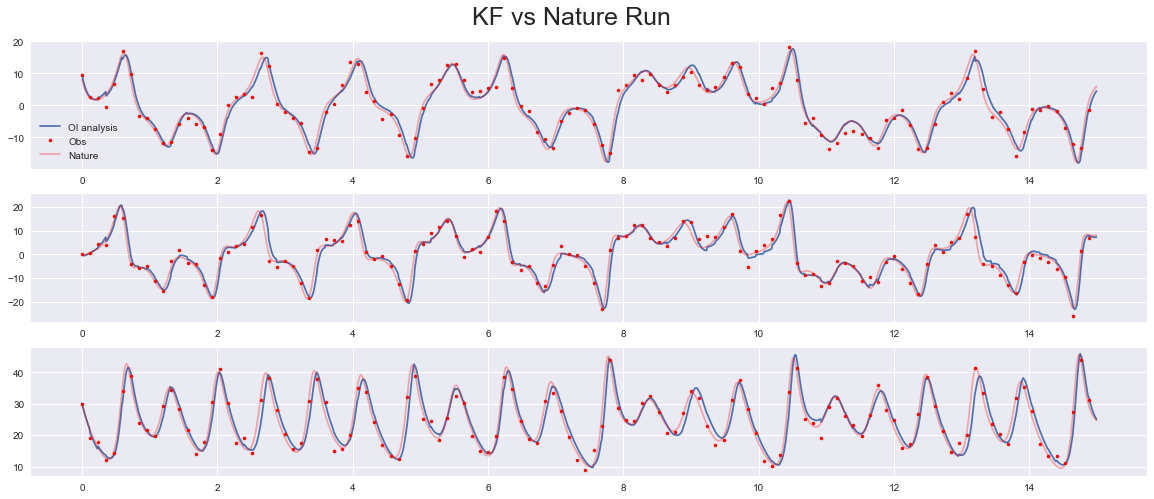

In [13]:
# from iterative NMC in test2
Pb = np.array([
    [ 95.92487549, 108.82721654,  13.52170192],
    [108.82721654, 135.97355097,  18.39642468],
    [ 13.52170192,  18.39642468,  64.98710037]
])
Pb *= 0.2

R = np.zeros((X_obs.shape[0], X_obs.shape[0]))
np.fill_diagonal(R, obs_var)


print('========Some Parameters=========')
print(f'cycle length (time interval between two observations): {obs_timeintv} sec')
print(f'number of cycle: {cycle_num}')
print(f'dt = {dt} sec')
print(f'initial value for experiment: {X_ini.ravel()}')
print(f'initial value for nature run: {X_nature[:,0]}')
print('=================================')

alpha = 0  # relaxation

cycle_len = obs_timeintv
result = np.zeros((X_ini.size, int(cycle_len*cycle_num/dt)))
xb = X_ini
t_start = 0
ts = np.arange(t_start, cycle_len, dt)

# start cycle assimilation
for nc in range(cycle_num):
    print('=== Pb ===')
    print(Pb)
    # calculate analysis field, then forecast
    xa, Pa = OI(xb, X_obs[:,[nc]], Pb, R)
    x = lorenz63_fdm(xa.ravel(), ts)
    result[:,nc*int(cycle_len/dt):(nc+1)*int(cycle_len/dt)] = x
    print('=== Pa ===')
    print(Pa)
        
    # for next cycle
    #Pb = 100 * M(xb[0,0], xb[1,0], xb[2,0], dt) @ Pa @ M(xb[0,0], xb[1,0], xb[2,0], dt).T
    Pb = alpha * Pb + (1-alpha) * M(xb[0,0], xb[1,0], xb[2,0], dt) @ Pa @ M(xb[0,0], xb[1,0], xb[2,0], dt).T
    Pb *= 1.2
    xb = x[:,[-1]]
    t_start = int(ts[-1] + dt)
    ts = np.arange(t_start, t_start+cycle_len, dt)
    
    
# plot assimilation result
ts = np.arange(0, time, dt)
t_obs = np.arange(0, time, obs_timeintv)

fig2, axs = plt.subplots(nrows=3, figsize=(20, 8))
for i in range(3):
    axs[i].plot(ts, result[i,:], label='OI analysis')
    axs[i].plot(t_obs, X_obs[i,:], 'r.', label='Obs')
    axs[i].plot(ts, X_nature[i,:], color='red', alpha=0.3, label='Nature')
    
axs[0].legend()

fig2.suptitle('KF vs Nature Run', fontsize=25, y=0.94);

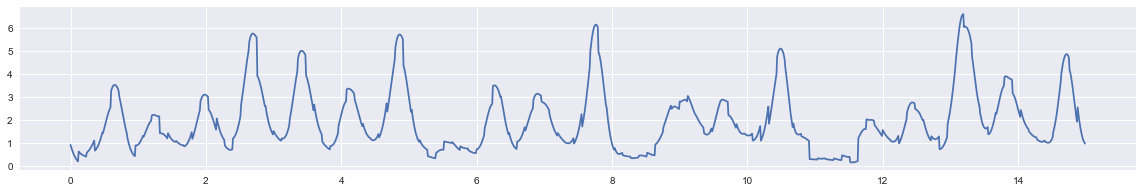

In [14]:
rmse = np.sqrt(np.mean((result-X_nature)**2, axis=0))
plt.figure(figsize=(20, 3))
plt.plot(ts, rmse)